## Model Training
Data cleaning process is done. Now we are ready to train our model. We will use SVM with rbf kernel tuned with heuristic finetuning

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
train_data = np.load('./Model_training_dataset.npz')
X = train_data['X_train']
y = train_data['y_train']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8682634730538922

In [4]:
print(f"sample size: {len(X_train)}")

sample size: 499


In [5]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80        46
           1       0.90      0.83      0.86        23
           2       0.78      0.88      0.83        43
           3       0.96      0.96      0.96        55

    accuracy                           0.87       167
   macro avg       0.87      0.86      0.86       167
weighted avg       0.87      0.87      0.87       167



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [6]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [7]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [8]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_train_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_train_score','best_params'])
df

,model,best_train_score,best_params
0,svm,0.885778,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.785616,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.891798,{'logisticregression__C': 1}


In [13]:
best_test_score = []
for algo in model_params.keys():
    best_test_score.append(best_estimators[algo].score(X_test,y_test))

df['best_test_score'] = best_test_score
df

,model,best_train_score,best_test_score,best_params
0,svm,0.885778,0.886228,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.785616,0.784431,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.891798,0.910180,{'logisticregression__C': 1}


In [14]:
best_clf = best_estimators['logistic_regression']

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[36,  5,  5,  0],
       [ 0, 23,  0,  0],
       [ 3,  0, 39,  1],
       [ 0,  1,  0, 54]], dtype=int64)

Text(69.0, 0.5, 'Truth')

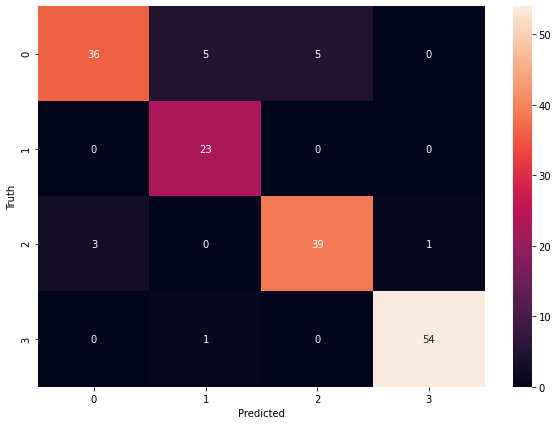

In [16]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [17]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']